In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import numpy as np

import cvxpy as cp
import MPC_prob
from utils import *
import pickle, os
from MPC_prob import MPC

from tqdm import tqdm
from para import paraset
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

C:\Users\msi\anaconda3\envs\coco\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\msi\anaconda3\envs\coco\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\msi\anaconda3\envs\coco\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


## Set prob parameters and save at MPC.config

In [31]:
N = 8
paraset(N=N,n_obs=5,Qs=1,Rs=0,num_probs=40000)

## Solve MICP problems to get samlpings for training

In [41]:
# #pass the value from config to dict and para
# relative_path = os.getcwd()
# dataset_name = 'STL_horizon_{}'.format(N)
# # dataset_name = 'NSTL_{}_horizon_{}'.format(Qs, N)
# config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')
#
# # config = [dataset_name, [prob_params] ,sampled_params]
# outfile = open(config_fn,"rb")
# config=pickle.load(outfile)
# outfile.close()
#
# train_fn = 'train_horizon_{}.p'.format(N)
# train_fn = os.path.join(relative_path, 'data', dataset_name, train_fn)
# test_fn = 'test_horizon_{}.p'.format(N)
# test_fn = os.path.join(relative_path, 'data', dataset_name, test_fn)
#
# all_params = ['N', 'Ak', 'Bk', 'Q', 'R', 'n_obs', \
#             'posmin', 'posmax', 'velmin', 'velmax', \
#             'umin', 'umax']
#
# param_dict={}
# i=0
# len_para = len(all_params)
# for param in all_params:
#     param_dict[param]= config[1][i]
#     i+=1
#     if i == len_para:
#         break
#
# N = param_dict['N']
# Ak = param_dict['Ak']
# Bk = param_dict['Bk']
# Q = param_dict['Q']
# R = param_dict['R']
# n_obs = param_dict['n_obs']
# umin = param_dict['umin']
# umax = param_dict['umax']
# sampled_params = config[2]
# n_obs = config[3]
# num_probs = config[4]
# border_size = config[5]
# box_buffer = config[6]
# min_box_size = config[7]
# max_box_size = config[8]
# posmin = config[9]
# posmax = config[10]
# velmin = config[11]
# velmax = config[12]
# n = config[13]
# m= config[14]
#
# obs_fix = config[15]
# xg_fix = config[16]
# if obs_fix:
#     obstacles = config[-1]
#
# config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')#
#
# prob = MPC(config=config_fn)
# #create numpy containers for data: (params, x, u, y, J*, solve_time)
# params = {}
# if 'x0' in sampled_params:
#     params['x0'] = np.zeros((num_probs,2*n))
# if 'xg' in sampled_params:
#     params['xg'] = np.zeros((num_probs,2*n))
# if 'obstacles' in sampled_params:
#     params['obstacles'] = np.zeros((num_probs, 4, n_obs))
#
# X = np.zeros((num_probs, 2*n, N));
# U = np.zeros((num_probs, m, N-1))
# Y = np.zeros((num_probs, 4*n_obs, N-1)).astype(int)
# Z = np.zeros((num_probs, 2*n_obs, N-1)).astype(int)
#
# costs = np.zeros(num_probs)
# solve_times = np.zeros(num_probs)
#
# prob.sampled_params = ['x0', 'xg', 'obstacles']
#
# #solving MICP
# ii_toggle = 0
# obs_new_ct = 5
# ii=0
# obstacles = config[-1]
#
# if obs_fix:
#     for ii in tqdm(range(num_probs)):
#         x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
#         params['obstacles'][ii,:] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
#         p_dict = {}
#         params['x0'][ii,:] = x0
#         xg= findIC(obstacles, posmin, posmax, velmin, velmax)
#         params['xg'][ii,:] = xg
#
#         p_dict['x0'] = params['x0'][ii,:]
#         p_dict['xg'] = params['xg'][ii,:]
#         p_dict['obstacles'] = params['obstacles'][ii,:]
#
#         prob_success = False
#         try:
#             # with time_limit(20):
#             prob_success, cost, solve_time, optvals = prob.solve_stl(p_dict, solver=cp.GUROBI)
#         except (KeyboardInterrupt, SystemExit):
#             raise
#         except:
#             print('solver failed at '.format(ii))
#
#         if prob_success:
#             costs[ii] = cost; solve_times[ii] = solve_time
#             X[ii,:,:], U[ii,:,:], Y[ii,:,:], Z[ii,:,:] = optvals
#             ii += 1
# else:
#     print('choose to fix obstalce')
#
#
# ## shuffle the data because of the spatial orders
# num_train = int(num_probs*0.9)
# arr = np.arange(num_probs)
# np.random.shuffle(arr)
#
# if 'x0' in sampled_params:
#     params['x0'] = params['x0'][arr]
# if 'xg' in sampled_params:
#     params['xg'] = params['xg'][arr]
# if 'obstacles' in sampled_params:
#     params['obstacles'] = params['obstacles'][arr]
#
# costs = costs[arr]
# solve_times = solve_times[arr]
#
#
# X = X[arr]
# U = U[arr]
# Y = Y[arr]
# Z = Z[arr]
#
# train_params = {}; test_params = {}
# if 'x0' in sampled_params:
#     train_params['x0'] = params['x0'][:num_train,:]
#     test_params['x0'] = params['x0'][num_train:,:]
# if 'obstacles' in sampled_params:
#     train_params['obstacles'] = params['obstacles'][:num_train,:]
#     test_params['obstacles'] = params['obstacles'][num_train:,:]
# if 'xg' in sampled_params:
#     train_params['xg'] = params['xg'][:num_train,:]
#     test_params['xg'] = params['xg'][num_train:,:]
#
# train_data = [train_params]
# train_data += [X[:num_train,:,:], U[:num_train,:,:], Y[:num_train,:,:],Z[:num_train,:,:]]
# train_data += [costs[:num_train], solve_times[:num_train]]
#
# test_data = [test_params]
# test_data += [X[num_train:,:,:], U[num_train:,:,:], Y[num_train:,:,:], Z[:num_train,:,:]]
# test_data += [costs[num_train:], solve_times[num_train:]]
#
# train_file = open(train_fn,'wb')
# pickle.dump(train_data,train_file); train_file.close()
#
# test_file = open(test_fn, 'wb')
# pickle.dump(test_data,test_file); test_file.close()

## Load train/test data

In [34]:
#load train/test data
n_obs= 5

dataset_name = 'MPC_horizon_{}_obs_{}'.format(N,n_obs)
# dataset_name = 'NSTL_{}_horizon_{}'.format(Qs, N)
# dataset_name = 'Fo_Mxg_Q_{}_horizon_{}'.format(Qs, N)
# dataset_name = 'default_horizon_{}'.format(N)
# dataset_name = 'obs_fix_{}'.format(N)
# dataset_name = 'default'

#加载设置文件地址，config = [dataset_name, prob_params, sampled_params]#
relative_path = os.getcwd()
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

config_file = open(config_fn,'rb')
config=pickle.load(config_file)

dataset_name =  config[0]
prob_params = config[1]
sampled_params = config[2]
config_file.close()

## Set problem according to the config file

In [18]:
N = 31
n_obs =5

paraset(N=N,n_obs=n_obs,Qs=1,Rs=0,num_probs=40000)

dataset_name = 'MPC_horizon_{}_obs_{}'.format(N,n_obs)
relative_path = os.getcwd()
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')
config_file = open(config_fn,'rb')
config=pickle.load(config_file)

prob = MPC(config=config_fn)

## set initial position and final position
x0 = [3.5,1.75,0,0]
xg = [2,2.5,0,0]
obstacles = config[-1]

prob_params = {}
prob_params['obstacles'] =  np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
prob_params['x0'] = x0
prob_params['xg'] = xg
prob = MPC(config=config_fn)


_, _, solvetime_g, optvals_g = prob.solve_stl(prob_params, solver=cp.GUROBI,verbose=True)

                                     CVXPY                                     
                                    v1.1.20                                    
(CVXPY) Oct 22 12:17:41 PM: Your problem has 1084 variables, 2259 constraints, and 28 parameters.
(CVXPY) Oct 22 12:17:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 22 12:17:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 22 12:17:41 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Oct 22 12:17:41 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Oct 22 12:17:41 PM: Applying reduction Dcp2Cone
(CVXPY) Oct 22 12:17:42 PM: Applying reduction CvxAttr2Const

In [19]:
_, _, solvetime_g, optvals_g = prob.solve_micp(prob_params, solver=cp.GUROBI,verbose=True)

                                     CVXPY                                     
                                    v1.1.20                                    
(CVXPY) Oct 22 12:17:46 PM: Your problem has 784 variables, 1059 constraints, and 28 parameters.
(CVXPY) Oct 22 12:17:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 22 12:17:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 22 12:17:47 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Oct 22 12:17:47 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Oct 22 12:17:47 PM: Applying reduction Dcp2Cone
(CVXPY) Oct 22 12:17:47 PM: Applying reduction CvxAttr2Constr

In [35]:
prob = MPC(config=config_fn)

relative_path = os.getcwd()
dataset_fn = relative_path + '/data/' + dataset_name

##load train data
train_file = open(dataset_fn+'/train_horizon_{}.p'.format(N),'rb')
# train_file = open(dataset_fn+'/train.p','rb')
train_data = pickle.load(train_file)
p_train, x_train, u_train, y_train, z_train, c_train, times_train = train_data
train_file.close()


x_train = train_data[1] #X sequence
y_train = train_data[3] #Y sequence

##load test data
test_file = open(dataset_fn+'/test_horizon_{}.p'.format(N),'rb')
# test_file = open(dataset_fn+'/test.p','rb')
# p_test, x_test, u_test, y_test, c_test, times_test = pickle.load(test_file)
test_data = pickle.load(test_file)
p_test, x_test, u_test, y_test,z_test,c_test, times_test = test_data
test_file.close()

### Load netwrok

In [36]:
from solvers.OMISTL import OMISTL

system = 'MPC'
prob_features = ['x0','xg','obstacles']
# prob_features = ['x0','xg','obstacles_map']

MPC_obj = OMISTL(system, prob, prob_features)

n_features = 33
MPC_obj.construct_strategies(n_features, train_data)
print('Find number of strategires: '+ str(MPC_obj.n_strategies))

MPC_obj.setup_network()
fn_saved = '..\models/MPC_horizon_{}_obs_{}.pt'.format(N)
MPC_obj.load_network(fn_saved)

Find number of strategires: 707
No existing model!


Loading presaved classifier model from ..\models/MPC_horizon_8_obs_5.pt


## Train model

In [6]:
# MPC_obj.training_params['TRAINING_ITERATIONS'] = 500
# MPC_obj.train(train_data=train_data, verbose=True)
# MPC_obj.model

NameError: name 'MPC_obj' is not defined

### train model with different horizons

In [ ]:
# def train_horizon_N(N, device_id=0):
#     relative_path = os.getcwd()
#     config_fn = relative_path + '/config/STL_horizon_{}.p'.format(N)
#     config_file = open(config_fn,'rb')
#     config =  pickle.load(config_file)
#     dataset_name = config[0]; config_file.close()
#
#     dataset_fn = relative_path + '/data/' + dataset_name
#
#     train_fn = os.path.join(dataset_fn, 'train_horizon_{}.p'.format(N))
#     train_file = open(train_fn,'rb')
#     train_data = pickle.load(train_file)
#     train_file.close()
#     x_train = train_data[1]
#     y_train = train_data[3]
#
#     test_fn = os.path.join(dataset_fn, 'test_horizon_{}.p'.format(N))
#     test_file = open(test_fn,'rb')
#     test_data = pickle.load(test_file)
#     p_test, x_test, u_test, y_test,z_test, c_test, times_test = test_data
#     test_file.close()
#
#     n_test = x_test.shape[0]
#
#     system = 'free_flyer'
#     prob_features = ['x0', 'xg', 'obstacles']
#
#     prob = MPC(config=config_fn)
#     mlopt = OMISTL(system, prob, prob_features)
#
#     n_features = 33
#     mlopt.construct_strategies(n_features, train_data)
#
#     print('Number of strategies for horizon {}: {}'.format(N, mlopt.n_strategies))
#
#     mlopt.setup_network(device_id=device_id)
#     mlopt.training_params['TRAINING_ITERATIONS'] =500
#     mlopt.train(train_data=train_data, verbose=True)
# train_horizon_N(8)

### Set problem and test dataset

In [49]:
velmin = -0.2
velmax = 0.2
posmin = np.zeros(2)

ft2m = 0.3048
posmax = ft2m*np.array([12.,9.])
max_box_size = 0.75
min_box_size = 0.25
box_buffer = 0.025
border_size = 0.05

obstacles = config[-1]
# obstacles = \
#         random_obs(n_obs, posmin, posmax, border_size, box_buffer, min_box_size, max_box_size)

obstacles= config[-1]

## Calculating shortest path using network

In [50]:
import time
t0=time.time()
prob_success = False

## set initial position and final position
x0 = [3.5,1.75,0,0]
xg = [2,2.5,0,0]
# x0 = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)
# xg = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)


##
while not prob_success:
    prob_params = {}
    prob_params['obstacles'] =  np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
    prob_params['x0'] = x0
    prob_params['xg'] = xg
    prob_success, cost, total_time, n_evals, optvals,y_guess = MPC_obj.forward(prob_params, solver=cp.GUROBI, max_evals=10)
    if prob_success:
        Xopt = optvals[0]

_, _, solvetime_g, optvals_g = prob.solve_stl(prob_params, solver=cp.GUROBI)
# _, _, solvetime_m, optvals_g = prob.solve_stl(prob_params, solver=cp.MOSEK)

print('Machine learning solve time (red points) : '+ str(total_time))
print('Gurobi solve time (blue points): '+ str(solvetime_g))
print('MOSEK solve time: '+ str(solvetime_m))

Machine learning solve time (red points) : 0.0
Gurobi solve time (blue points): 0.2812480926513672


## Plot

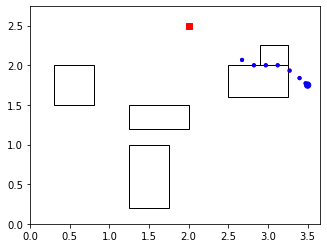

In [51]:
Xopt_g = optvals_g[0]

obstacles = []
for ii_obs in range(n_obs):
    obs = prob_params['obstacles'][:,ii_obs]
    obstacles.append(obs)

if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='white', ec='black')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')


    xg = prob_params['xg']
    x0 = prob_params['x0']
    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="blue")
    plt.gca().add_patch(circle)

    #blue line is network prediction
    plt.plot(xg[0],xg[1],'sr')
    # plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])#plot using arrows
    for jj in range(N):
        circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.02, fc='red',ec="red")
        plt.gca().add_patch(circle)

    #red line is Gurobi
    for jj in range(N):
        circle = plt.Circle((Xopt_g[0,jj],Xopt_g[1,jj]), 0.02, fc='blue',ec="blue")
        plt.gca().add_patch(circle)

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

## MPC control for shortest path

### Set initial point and reference point

In [65]:
## set initial points and reference points
ref_list = []
num_ref = 3
x0 = [0.5,0.5,0,0]

#use default reference points
ref_1 = [0.6,2.3,0,0]
ref_list.append(ref_1)
ref_2 = [3.5,2.2,0,0]
ref_list.append(ref_2)
ref_3 = [3,1,0,0]
ref_list.append(ref_3)

# or generate reference points use different random seeds
# seed = 2
# for i in range(num_ref):
#     ref = list(findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax, seed =i+seed))
#     ref[2]=0
#     ref[3]=0
#     ref_list.append(ref)
ref_list

[[0.6, 2.3, 0, 0], [3.5, 2.2, 0, 0], [3, 1, 0, 0]]

In [66]:
from MPC_control import MPC_controller

mpc_time = 600
prob = MPC(config=config_fn)

Xopt,Uopt,Yopt,T_total = MPC_controller(x0,ref_list,prob=prob,MPC_obj=MPC_obj,T=mpc_time)

Found solution at t =  0. n_evals = 1
Found solution at t =  1. n_evals = 1
Found solution at t =  2. n_evals = 1
Found solution at t =  3. n_evals = 1
continue original path at t= 4
continue original path at t= 5
continue original path at t= 6
continue original path at t= 7
continue original path at t= 8
continue original path at t= 9
Found solution at t =  10. n_evals = 1
Found solution at t =  11. n_evals = 1
Found solution at t =  12. n_evals = 1
Found solution at t =  13. n_evals = 1
Found solution at t =  14. n_evals = 1
Found solution at t =  15. n_evals = 1
Found solution at t =  16. n_evals = 1
Found solution at t =  17. n_evals = 1
Found solution at t =  18. n_evals = 1
Found solution at t =  19. n_evals = 1
continue original path at t= 20
continue original path at t= 21
continue original path at t= 22
continue original path at t= 23
continue original path at t= 24
continue original path at t= 25
continue original path at t= 26
Found solution at t =  27. n_evals = 8
Found sol

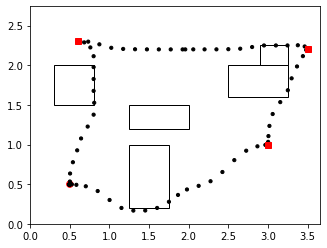

total solving time for 600 steps is 3.640950918197632
avarage solving time at each step is 0.0060682515303293865


In [72]:
#plot results
obstacles = []
x0 = [0.5,0.5,0,0]
x_init = x0
for ii_obs in range(n_obs):
    # obs = test_data[0]['obstacles'][idx][:,ii_obs]
    obs = prob_params['obstacles'][:,ii_obs]
    obstacles.append(obs)

# x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
x0 = prob_params['x0']
xg = prob_params['xg']


if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='white', ec='black')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x_init[0],x_init[1]), 0.04, fc='red',ec="red")
    plt.gca().add_patch(circle)

    for i in range(num_ref):
        plt.plot(ref_list[i][0],ref_list[i][1],'sr')
    #plot using arrows
    # for jj in range(len(Xopt[:,0])):
    #     plt.quiver(Xopt[jj][0], Xopt[jj][0])
    #     circle = plt.Circle((Xopt[jj][0],Xopt[jj][1]), 0.02, fc='blue',ec="blue")

    # for jj in range(len(Xopt[:,0])):
    #     plt.quiver(Xopt[jj][0], Xopt[jj][1], Xopt[jj][2], Xopt[jj][3])

    for jj in range(len(Xopt[:,0])):
        circle = plt.Circle((Xopt[jj][0],Xopt[jj][1]), 0.02, fc='black',ec="black")
        plt.gca().add_patch(circle)

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

print('total solving time for {} steps is '.format(mpc_time) +str(T_total))
print('avarage solving time at each step is ' +str(T_total/mpc_time))